In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        pass
        # print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
import torch
import random
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import wandb
from tqdm.notebook import tqdm

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
import random
import numpy as np
import torch

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if using multi-GPU

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


In [ ]:
# import os
# import torch
# from torchvision import datasets, transforms
# from torch.utils.data import DataLoader, Subset
# from sklearn.model_selection import train_test_split
# import numpy as np

# def get_dataloaders(data_dir, batch_size=32, val_split=0.2, augment=False, image_size=(224, 224)):
#     """
#     Loads the iNaturalist dataset, applies transformations, and splits the training set while maintaining class balance.
#     Parameters:
#         data_dir (str): Path to dataset containing 'train' and 'test' folders.
#         batch_size (int): Batch size for DataLoader.
#         val_split (float): Fraction of training data to use for validation.
#         augment (bool): Whether to apply data augmentation to training data only.
#         image_size (tuple): Target image size for resizing.
#     Returns:
#         train_loader, val_loader, test_loader, tiny_loader
#     """

#     # Define transforms
#     basic_transform = transforms.Compose([
#         transforms.Resize(image_size),
#         transforms.ToTensor(),
#         transforms.Normalize(mean=[0.4712, 0.4600, 0.3896], std=[0.1935, 0.1877, 0.1843])
#     ])

#     augmented_transform = transforms.Compose([
#         transforms.Resize(image_size),
#         transforms.RandomHorizontalFlip(),
#         transforms.RandomRotation(15),
#         transforms.ToTensor(),
#         transforms.Normalize(mean=[0.4712, 0.4600, 0.3896], std=[0.1935, 0.1877, 0.1843])
#     ]) if augment else basic_transform

#     # Load full training set with basic transform just to get labels
#     base_dataset = datasets.ImageFolder(root=os.path.join(data_dir, "train"), transform=basic_transform)

#     # Stratified split
#     train_indices, val_indices = stratified_split(base_dataset, val_split)

#     # Separate datasets using different transforms
#     train_dataset = datasets.ImageFolder(root=os.path.join(data_dir, "train"), transform=augmented_transform)
#     val_dataset   = datasets.ImageFolder(root=os.path.join(data_dir, "train"), transform=basic_transform)

#     train_subset = Subset(train_dataset, train_indices)
#     val_subset   = Subset(val_dataset, val_indices)
#     tiny_train   = Subset(train_subset, indices=range(512))
    
#     test_dataset = datasets.ImageFolder(root=os.path.join(data_dir, "val"), transform=basic_transform)

#     g = torch.Generator()
#     g.manual_seed(42)

#     train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, generator=g)
#     val_loader   = DataLoader(val_subset, batch_size=batch_size, shuffle=False, generator=g)
#     test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, generator=g)
#     tiny_loader  = DataLoader(tiny_train, batch_size=16, shuffle=True, generator=g)

#     return train_loader, val_loader, test_loader, tiny_loader

# def stratified_split(dataset, val_split):
#     """
#     Splits dataset into training and validation sets with class balance.
#     """
#     labels = np.array(dataset.targets)
#     train_indices, val_indices = train_test_split(
#         np.arange(len(labels)), test_size=val_split, stratify=labels, random_state=42
#     )
#     return train_indices, val_indices


In [7]:
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
import numpy as np

def get_dataloaders(data_dir, batch_size=32, val_split=0.2, augment=False, image_size=(224, 224), whole_train = False):
    """
    Loads the iNaturalist dataset, applies transformations, and splits the training set while maintaining class balance.
    Parameters:
        data_dir (str): Path to dataset containing 'train' and 'test' folders.
        batch_size (int): Batch size for DataLoader.
        val_split (float): Fraction of training data to use for validation.
        augment (bool): Whether to apply data augmentation to training data only.
        image_size (tuple): Target image size for resizing.
    Returns:
        train_loader, val_loader, test_loader, tiny_loader
    """

    # Define transforms
    basic_transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.4712, 0.4600, 0.3896], std=[0.1935, 0.1877, 0.1843])
    ])

    augmented_transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.4712, 0.4600, 0.3896], std=[0.1935, 0.1877, 0.1843])
    ]) if augment else basic_transform

    # Load full training set with basic transform just to get labels
    base_dataset = datasets.ImageFolder(root=os.path.join(data_dir, "train"), transform=basic_transform)

    # Stratified split
    train_indices, val_indices = stratified_split(base_dataset, val_split)

    # Separate datasets using different transforms
    train_dataset = datasets.ImageFolder(root=os.path.join(data_dir, "train"), transform=augmented_transform)
    if whole_train:
        test_dataset = datasets.ImageFolder(root=os.path.join(data_dir, "val"), transform=basic_transform)
        g = torch.Generator()
        g.manual_seed(42)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=g)
        test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, generator=g)
        return train_loader , test_loader

        
    val_dataset   = datasets.ImageFolder(root=os.path.join(data_dir, "train"), transform=basic_transform)

    train_subset = Subset(train_dataset, train_indices)
    val_subset   = Subset(val_dataset, val_indices)
    tiny_train   = Subset(train_subset, indices=range(512))
    
    test_dataset = datasets.ImageFolder(root=os.path.join(data_dir, "val"), transform=basic_transform)

    g = torch.Generator()
    g.manual_seed(42)

    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, generator=g)
    val_loader   = DataLoader(val_subset, batch_size=batch_size, shuffle=False, generator=g)
    test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, generator=g)
    tiny_loader  = DataLoader(tiny_train, batch_size=16, shuffle=True, generator=g)

    return train_loader, val_loader, test_loader, tiny_loader

def stratified_split(dataset, val_split):
    """
    Splits dataset into training and validation sets with class balance.
    """
    labels = np.array(dataset.targets)
    train_indices, val_indices = train_test_split(
        np.arange(len(labels)), test_size=val_split, stratify=labels, random_state=42
    )
    return train_indices, val_indices


In [8]:
data_dir = "/kaggle/input/nature-12k/inaturalist_12K"  # Replace with your dataset path
# train_loader, val_loader, test_loader, tiny_loader = get_dataloaders(data_dir, augment=True)
train_loader , test_loader = get_dataloaders(data_dir, augment=True , whole_train=True)

torch.Size([3, 224, 224])
tensor(1)


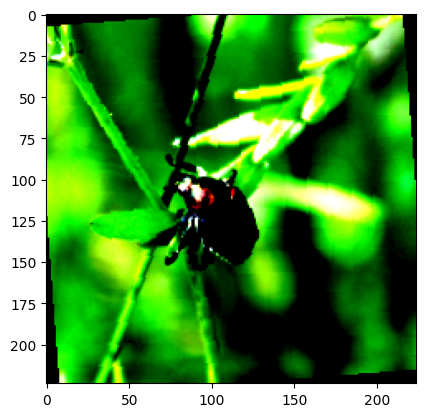

In [9]:
import matplotlib.pyplot as plt
import numpy as np

for i in train_loader:
    a , b = i
    print(a[15].shape)
    plt.imshow(np.transpose(a[0].numpy(), (1, 2, 0)))
    print(b[15])
    # print(i[0][0].shape)
    break

In [10]:
# import torch

# from tqdm import tqdm
import torch.nn as nn

class FlexibleCNN(nn.Module):
    def __init__(self, 
                 input_shape=(3, 224, 224),
                 num_classes=10,
                 num_filters=[64, 64, 64,64,64],
                 kernel_size=5,
                 dropout=0.3,
                 batch_norm=True,
                 conv_activation='ReLU',
                 pooling='max',
                 pooling_kernel_size=2,
                 pooling_stride=2,
                 output_activation='softmax',
                 dense_neurons=512):
        super(FlexibleCNN, self).__init__()
        
        self.conv_layers = torch.nn.ModuleList()
        in_channels = input_shape[0]
        
        for filters in num_filters:
            self.conv_layers.append(torch.nn.Conv2d(in_channels, filters, kernel_size=kernel_size, padding=1))
            if batch_norm:
                self.conv_layers.append(torch.nn.BatchNorm2d(filters))
            self.conv_layers.append(getattr(torch.nn, conv_activation)())
            if pooling == 'max':
                self.conv_layers.append(torch.nn.MaxPool2d(kernel_size=pooling_kernel_size, stride=pooling_stride))
            in_channels = filters
        
        self.flatten_size = self._get_flatten_size(input_shape)
        self.dense_layer = torch.nn.Linear(self.flatten_size, dense_neurons)
        self.dense_activation = getattr(torch.nn, conv_activation)()
        self.dropout = torch.nn.Dropout(dropout)
        self.output_layer = torch.nn.Linear(dense_neurons, num_classes)
        self.output_activation = torch.nn.Softmax(dim=1) if output_activation == 'softmax' else torch.nn.Identity()

    def _get_flatten_size(self, input_shape):
        x = torch.rand(1, *input_shape)
        with torch.no_grad():
            for layer in self.conv_layers:
                x = layer(x)
        return x.view(1, -1).size(1)

    def forward(self, x):
        for layer in self.conv_layers:
            x = layer(x)
        x = torch.flatten(x, start_dim=1)
        x = self.dense_layer(x)
        # x = self.dense_activation(x)
        x = self.dropout(x)
        x = self.output_layer(x)
        return x

    def compute_total_params_and_ops(self, input_shape):
        total_params = 0
        total_ops = 0
        h, w = input_shape[1], input_shape[2]
        in_channels = input_shape[0]

        for layer in self.conv_layers:
            if isinstance(layer, nn.Conv2d):
                k = layer.kernel_size[0]
                out_h, out_w = h // 2, w // 2
                total_ops += out_h * out_w * layer.out_channels * in_channels * k * k
                total_params += (in_channels * k * k + 1) * layer.out_channels
                h, w, in_channels = out_h, out_w, layer.out_channels

        total_params += (self.flatten_size + 1) * self.dense_layer.out_features
        total_ops += self.flatten_size * self.dense_layer.out_features

        total_params += (self.dense_layer.out_features + 1) * self.output_layer.out_features
        total_ops += self.dense_layer.out_features * self.output_layer.out_features

        return total_params, total_ops

    def train_model(self, train_loader, val_loader, device,learning_rate=0.1, epochs=5,wandb=None ):
        self.to(device)
        criterion = torch.nn.CrossEntropyLoss().to(device)

        # criterion = torch.nn.CrossEntropyLoss().to(device)
        optimizer = optim.Adam(self.parameters(), lr=learning_rate, weight_decay=1e-3)

        for epoch in tqdm(range(epochs), desc="Training Progress",position=0):
        # for epoch in range(epochs):
            self.train()
            running_loss, correct, total = 0.0, 0, 0

            for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}",position=1):
            # for images, labels in train_loader:
                images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
                # print(images.shape, labels.shape)
                optimizer.zero_grad()
                outputs = self(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

            train_loss = running_loss / total
            train_acc = correct / total

            val_loss, val_acc = self.validate(val_loader, criterion, device)

            if wandb:
                wandb.log({"train_loss": train_loss, "train_acc": train_acc,"val_loss": val_loss, "val_acc": val_acc})
            print(f"Epoch {epoch+1}: Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f},train_loss: {train_loss:.4f},val_loss: {val_loss:.4f}")

    def validate(self, val_loader, criterion, device):
        self.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
                outputs = self(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        return val_loss / total, correct / total


In [11]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("dl2wandb")


In [12]:
wandb.login(key=secret_value_0)


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: da24s021 (da24s021-indian-institute-of-technology-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [14]:
sweep_config = {
        "method": "random",
        "metric": {"name": "val_acc", "goal": "maximize"},
        "parameters": {
            "num_filters": {"values": [ [32,64,128,256,512],[128,128,128,128,128]]},
            "kernel_size": {"values": [3]},
            "dropout": {"values": [0.2]},
            "batch_norm": {"values": [True]},
            "conv_activation": {"values": ["SiLU"]},
            "augment": {"values": [True]},
            "learning_rate": {"values":[0.0001]},
            "epochs": {"values": [20]}
        }
    }

In [15]:
import pprint
pprint.pprint(sweep_config)

{'method': 'random',
 'metric': {'goal': 'maximize', 'name': 'val_acc'},
 'parameters': {'augment': {'values': [True]},
                'batch_norm': {'values': [True]},
                'conv_activation': {'values': ['SiLU']},
                'dropout': {'values': [0.2]},
                'epochs': {'values': [20]},
                'kernel_size': {'values': [3]},
                'learning_rate': {'values': [0.0001]},
                'num_filters': {'values': [[32, 64, 128, 256, 512],
                                           [128, 128, 128, 128, 128]]}}}


In [16]:
data_dir = "/kaggle/input/nature-12k/inaturalist_12K" 

In [17]:
sweep_id = wandb.sweep(sweep_config, project="DA6401_assignment2")


Create sweep with ID: 4y9aku9i
Sweep URL: https://wandb.ai/da24s021-indian-institute-of-technology-madras/DA6401_assignment2/sweeps/4y9aku9i


In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train(config=None , data_dir = data_dir):
    
    # Initialize a new wandb run
    run = wandb.init(config = config,
                    project="DA6401_assignment2",
                    resume = "allow")
    # run.mark_preempting()

    # with wandb.init(config=config):
        # If called by wandb.agent, as below,
        # this config will be set by Sweep Controller
    config = wandb.config

    wandb.run.name=f"run on Test Data-{wandb.run.id},num_filters-{config.num_filters}"
    wandb.run.save()
    train_loader, val_loader, test_loader, tiny_loader = get_dataloaders(data_dir, augment=config.augment)
    # loader = build_dataset(config.batch_size)
    set_seed(42)
    nn = FlexibleCNN(num_filters=config.num_filters , kernel_size = config.kernel_size, dropout = config.dropout ,batch_norm = config.batch_norm,
                    conv_activation = config.conv_activation, )

    nn.train_model(train_loader= train_loader, val_loader=val_loader, device= device,learning_rate=config.learning_rate, epochs=config.epochs,wandb = run)
    run.finish()
    # network = build_network(config.fc_layer_size, config.dropout)
    # optimizer = build_optimizer(network, config.optimizer, config.learning_rate)

    # for epoch in range(config.epochs):
    #     avg_loss = train_epoch(network, loader, optimizer)
    #     wandb.log({"loss": avg_loss, "epoch": epoch})     

In [ ]:
wandb.agent(sweep_id, train)

wandb: Agent Starting Run: rvkd35s6 with config:
wandb: 	augment: True
wandb: 	batch_norm: True
wandb: 	conv_activation: SiLU
wandb: 	dropout: 0.2
wandb: 	epochs: 20
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.0001
wandb: 	num_filters: [128, 128, 128, 128, 128]


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


wandb: WARNING Calling wandb.run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


Training Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 1: Train Acc: 0.2525, Val Acc: 0.3125,train_loss: 2.1214,val_loss: 1.9899


Epoch 2/20:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 2: Train Acc: 0.3149, Val Acc: 0.3360,train_loss: 1.9459,val_loss: 1.9011


Epoch 3/20:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 3: Train Acc: 0.3433, Val Acc: 0.3545,train_loss: 1.8771,val_loss: 1.8579


Epoch 4/20:   0%|          | 0/250 [00:00<?, ?it/s]